In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt

import tqdm
from tqdm import tqdm

from sklearn.manifold import TSNE

import torch
import torch.nn.functional as F
import torch.utils.data as data_utils
from torch import nn
from torch.utils.data import random_split
from torch.utils.data import DataLoader, Dataset

from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision import transforms
import torchvision.models as models

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

In [3]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=transform,
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=transform,
)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw

Processing...


/home/paul/.local/lib/python3.8/site-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Done!


In [4]:
train_len = int(0.8 * len(training_data))
val_len = len(training_data) - train_len
torch.manual_seed(42)
train_data, val_data = random_split(training_data, [train_len, val_len])

In [5]:
len(train_data), len(val_data), len(test_data)

(48000, 12000, 10000)

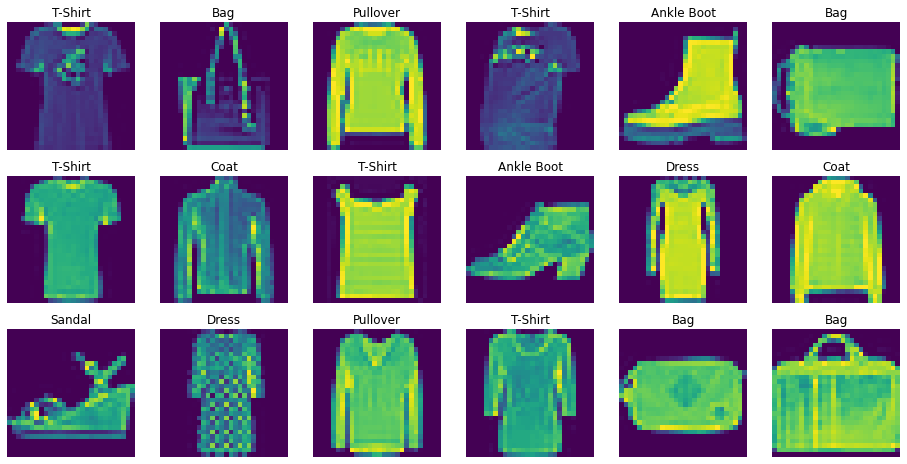

In [9]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

figure = plt.figure(figsize=(16, 8))
cols, rows = 6, 3

for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze())

plt.show()

In [10]:
training_data[0][0].shape, training_data[0][1]

(torch.Size([1, 28, 28]), 9)

In [11]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

In [12]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [13]:
class Model(nn.Module):
    def __init__(self, in_channels=1, num_classes=10):
        super(Model, self).__init__()

        self.feature_extractor = nn.Sequential(            
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=4, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=4, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=4, stride=1),
            nn.Tanh()
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=num_classes),
        )


    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        probs = F.softmax(logits, dim=1)
        return logits, probs

In [14]:
model = Model(num_classes=len(labels_map))
model = model.to(device)

In [15]:
model

Model(
  (feature_extractor): Sequential(
    (0): Conv2d(1, 6, kernel_size=(4, 4), stride=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Conv2d(6, 16, kernel_size=(4, 4), stride=(1, 1))
    (4): Tanh()
    (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (6): Conv2d(16, 120, kernel_size=(4, 4), stride=(1, 1))
    (7): Tanh()
  )
  (classifier): Sequential(
    (0): Linear(in_features=120, out_features=84, bias=True)
    (1): Tanh()
    (2): Linear(in_features=84, out_features=10, bias=True)
  )
)

In [16]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [17]:
def train(dataloader, model, loss_fn, optimizer):
    model.train()

    for batch, (X, y) in enumerate(tqdm(dataloader)):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred, probs = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [18]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in tqdm(dataloader):
            X, y = X.to(device), y.to(device)
            pred, probs = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    
    return correct, test_loss

In [20]:
epochs = 20
train_acc = []
train_losses = []
test_acc = []
test_losses = []

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)

    train_correct, train_loss = test(train_dataloader, model, loss_fn)
    train_acc.append(train_correct)
    train_losses.append(train_loss)
    print(f"Train Error: \n Accuracy: {(100*train_correct):>0.1f}%, Avg loss: {train_loss:>8f} \n")

    test_correct, test_loss = test(test_dataloader, model, loss_fn)
    test_acc.append(test_correct)
    test_losses.append(test_loss)
    print(f"Test Error: \n Accuracy: {(100*test_correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

    # torch.save(model.state_dict(), f"models/model{t}.pth")

print("Done!")

Epoch 1
-------------------------------


  2%|█▉                                                                                          | 20/938 [00:02<01:53,  8.07it/s]


KeyboardInterrupt: 

In [ ]:
plt.plot(train_losses)

In [ ]:
plt.plot(test_losses)

In [ ]:
class SiameseDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        
    def __getitem__(self, index):
        img1, label1 = random.choice(self.dataset)

        #We need to approximately 50% of images to be in the same class
        should_get_same_class = random.randint(0, 1) 
        if should_get_same_class:
            while True:
                #Look untill the same class image is found
                img2, label2 = random.choice(self.dataset) 
                if label1 == label2:
                    break
        else:
            while True:
                #Look untill a different class image is found
                img2, label2 = random.choice(self.dataset) 
                if label1 != label2:
                    break
        
        return img1, img2, torch.from_numpy(np.array([int(label1 != label2)], dtype=np.float32))
    
    def __len__(self):
        return len(self.dataset)

In [ ]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()

        # Setting up the Fully Connected Layers
        self.fc = nn.Sequential(
            nn.Linear(240, 80),
            nn.BatchNorm1d(80),
            nn.ReLU(),
            nn.Linear(80, 30),
            nn.BatchNorm1d(30),
            nn.ReLU(),
            nn.Linear(30, 1),
            nn.Sigmoid(),
        )
    
    def forward(self, input1, input2):
        combined_features = torch.cat([input1, input2], dim=1)
        # combined_features = input1 * input2

        return self.fc(combined_features)

In [ ]:
siamese = SiameseNetwork()
siamese = siamese.to(device)

siamese_criterion = torch.nn.BCELoss()
siamese_optimizer = torch.optim.Adam(siamese.parameters(), lr = 0.001)

In [ ]:
train_datas = SiameseDataset(train_data)
val_datas = SiameseDataset(val_data)
test_datas = SiameseDataset(test_data)

siam_test_dataloader = DataLoader(test_datas, batch_size=batch_size)

In [ ]:
import copy

feature_model = copy.deepcopy(model)
feature_model.classifier = nn.Identity()
feature_model.eval()

In [ ]:
loss_history = []
correct_history = []

# Iterate throught the epochs
for epoch in tqdm(range(20)):

    total_loss, correct = 0, 0
    
    # Iterate over batches
    for img0, img1, label in siam_test_dataloader:
        img0, img1, label = img0.to(device), img1.to(device), label.to(device)

        img0, probs0 = feature_model(img0)
        img1, probs1 = feature_model(img1)

        prob = siamese(img0, img1)
        loss = siamese_criterion(prob, label)

        siamese_optimizer.zero_grad()
        loss.backward()
        siamese_optimizer.step()

        total_loss += loss.item()
        correct += torch.count_nonzero(label == (prob > 0.9)).item()

    print("Loss, Correct", total_loss, correct)
        
    loss_history.append(total_loss)
    correct_history.append(correct)

In [ ]:
plt.plot(loss_history)

In [ ]:
siamese.eval()

In [ ]:
img0 = test_data[1][0]
img1 = test_data[1][0]

img0 = img0.unsqueeze(1)
img1 = img1.unsqueeze(1)

img0 = img0.to(device)
img1 = img1.to(device)

img0, probs0 = feature_model(img0)
img1, probs1 = feature_model(img1)

print(img0.shape, img1.shape)

siamese(img0, img1)[0].item(), test_data[1][1], test_data[1][1]

In [ ]:
def find_similar(img0, dataset):
    res = []
    
    img0 = img0.unsqueeze(1)
    img0 = img0.to(device)
    img0, probs0 = feature_model(img0)
    
    for i in tqdm(range(len(dataset))):
        img1 = dataset[i][0]
        img1 = img1.unsqueeze(1)
        img1 = img1.to(device)
        img1, probs1 = feature_model(img1)
        
        res.append(siamese(img0, img1)[0].item())
        
    return res

In [ ]:
indices = torch.arange(0, 1000)
test_data_sub = data_utils.Subset(test_data, indices)

similar = find_similar(test_data[1][0], test_data_sub)

In [ ]:
sorted_similar = np.argsort(similar)

In [ ]:
most_similar_5 = sorted_similar[:5]

print("Most similar:", most_similar_5)

In [ ]:
print("Classes of most similar:", [labels_map[test_data_sub[i][1]] for i in most_similar_5])

In [ ]:
least_similar_5 = sorted_similar[-5:]

print("Least similar:", least_similar_5)

In [ ]:
print("Classes of least similar:", [labels_map[test_data_sub[i][1]] for i in least_similar_5])

In [ ]:
plt.imshow(test_data[1][0].squeeze(), cmap="gray")
plt.title(labels_map[test_data[1][1]])
plt.axis("off")
plt.show()

In [ ]:
figure = plt.figure(figsize=(15, 6))
cols, rows = 5, 2

for i in range(1, cols * rows + 1):
    if i < 6:
        sample_idx = most_similar_5[i - 1]
    else:
        sample_idx = least_similar_5[i - 6]
        
    img, label = test_data_sub[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(f'{labels_map[label]} {1.0 - similar[sample_idx]:.5f}')
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")

plt.show()

In [ ]:
def all_preds(dataloader):
    res = []

    for X, y in tqdm(dataloader):
        X = X.to(device)
        pred, prob = model(X)
        pred = pred.detach().cpu()

        for i in range(len(y)):
            res.append((pred[i].numpy(), y[i].numpy()))
    
    return res

In [ ]:
features = [p[0] for p in all_preds(test_dataloader)]
labels = [p[1] for p in all_preds(test_dataloader)]

In [ ]:
tsne = TSNE(n_components=2, init='pca', random_state=42, method='barnes_hut', n_iter=500, verbose=2)
tsne_features = tsne.fit_transform(features)

In [ ]:
obj_categories = list(labels_map.values())
colors = plt.cm.rainbow(np.linspace(0, 1, 10))
plt.figure(figsize=(10, 10))

for c_group, (c_color, c_label) in enumerate(zip(colors, obj_categories)):
    plt.scatter(tsne_features[np.where(np.array(labels) == c_group), 0], tsne_features[np.where(np.array(labels) == c_group), 1], 
                marker='o', color=c_color, linewidth=1, alpha=0.8, label=c_label)
    
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('t-SNE on Testing Samples')
plt.legend(loc='best')
plt.show(block=False)